# Chapter 1: Logistic Regression 
## Section  1: Preprocessing the data
--------------------------------------------------------------------------------------------------------------------------------------------------


### Methodology
We will start with trying out logistic regression on a realtively small dataset, particularly the https://archive.ics.uci.edu/dataset/470/parkinson+s+disease+classification dataset.

Since our problem relies on voice features, due to the motor-related nature of PD, we will need to see which features are most important. We will look at preprocessed datasets first, keeping note of the most important features, and trying to generalize at the end to be able to fully extract the needed features for a highly accurate classification from raw voices, and be able to predict early PD from that.


Important libraries, put in one block cell to make it easier to run other cells without dependancy on a library found randomly on some cell (won't put libraries used in only 1 cell, wil keep them only in the cell).

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, learning_curve

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score, mean_squared_error, mean_absolute_error,r2_score,accuracy_score, classification_report, confusion_matrix,roc_curve, auc, roc_auc_score, precision_recall_curve,average_precision_score, log_loss, brier_score_loss
n_job = 6 # Adjust  to your machine, less = less load, each n is a core

### Extract Data

Make the data ready to be used:

In [10]:
df = pd.read_csv("parkinsons.data")

#Separate features and target
X = df.drop(columns=["name", "status"]) #No need for these in data
y = df["status"]
groups = df["name"] #Use name as group divider (naturally)
print(f"size of X:{X.shape}")

size of X:(195, 22)


**We will do a simple showing of the correlations of the features to the output, just to get an idea of the most important features, as well as the features to themselves to see which are redundant.**


Feature correlations with Parkinson's status:
spread1                   0.565
PPE                       0.531
spread2                   0.455
MDVP:Shimmer              0.367
MDVP:APQ                  0.364
Shimmer:APQ5              0.351
MDVP:Shimmer(dB)          0.351
Shimmer:APQ3              0.348
Shimmer:DDA               0.348
D2                        0.340
MDVP:Jitter(Abs)          0.339
RPDE                      0.309
MDVP:PPQ                  0.289
MDVP:Jitter(%)            0.278
MDVP:RAP                  0.267
Jitter:DDP                0.267
DFA                       0.232
NHR                       0.189
MDVP:Fhi(Hz)              -0.166
HNR                       -0.362
MDVP:Flo(Hz)              -0.380
MDVP:Fo(Hz)               -0.384


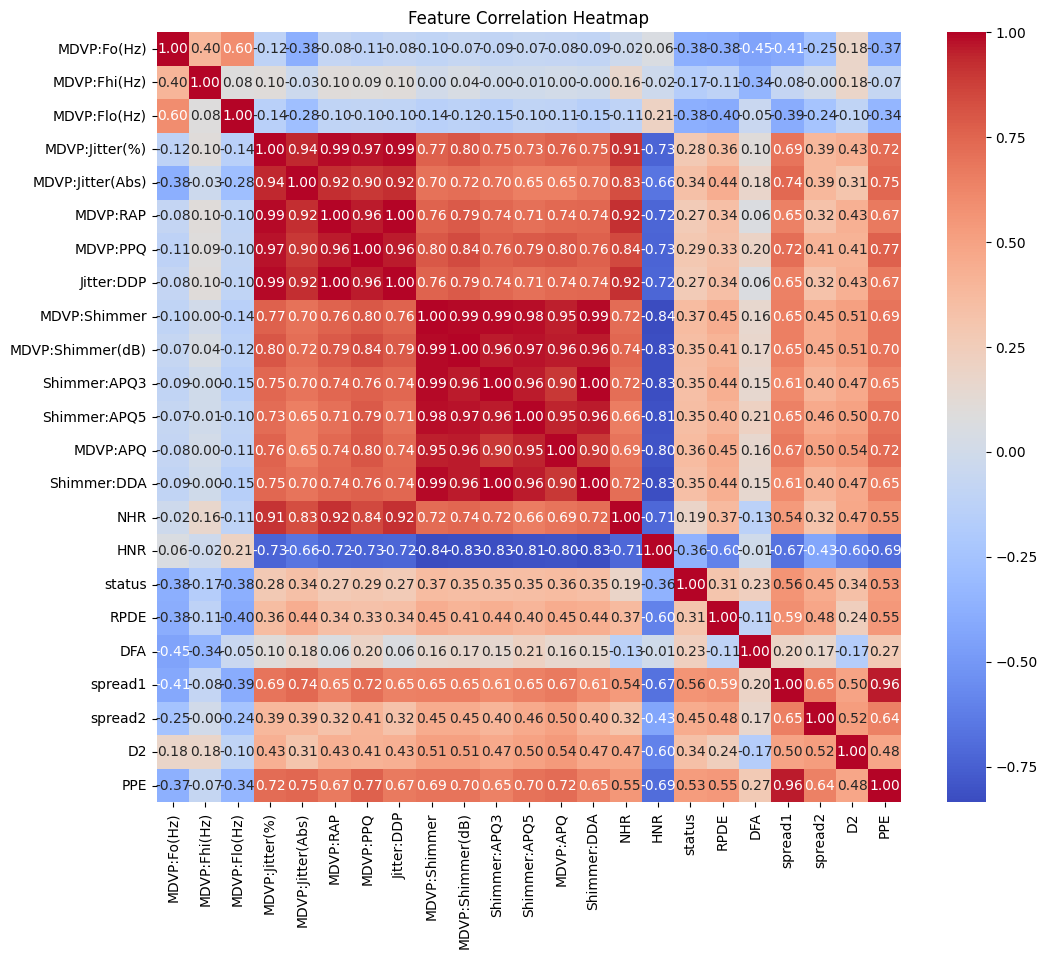

In [11]:
#find correlation between status and variables
corr = df.drop(columns=["name"]).corr()["status"].sort_values(ascending=False)

print("\nFeature correlations with Parkinson's status:")
for feature, value in corr.drop("status").items():
    print(f"{feature:25s} {value:.3f}")


#plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.drop(columns=["name"]).corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

We notice a lot of redundancy as apparent from the very high (0.94+) correlation values between features.

We then notice, a lot of our features are the same feature, but measured in different measurement, such as MDVP:Jitter(%), and MDVP:Jitter(Abs), being metrics for the same thing. Keeping both featrues is redundant and adds noise for no reason, so we will drop one of the two, and do the same thing for all features that have such redundancy existing in it (Apq3*3 = DDA, db vs raw, RAP vs DDP).

Additionally, NHR and HNR carry the same info (noise to harmonics ratio, and vice versa), so we will drop one, HNR (NHR is a simpler scale, sicne it's linear not logarithmic).

MDVP:Fo(Hz)              
MDVP:Fhi(Hz)             
MDVP:Flo(Hz)             
MDVP:Jitter(%)           
MDVP:RAP                 
MDVP:PPQ                 
MDVP:Shimmer(dB)         
Shimmer:APQ3             
Shimmer:APQ5             
MDVP:APQ                 
NHR                      
RPDE                     
DFA                      
spread1                  
spread2                  
D2                       
PPE                      


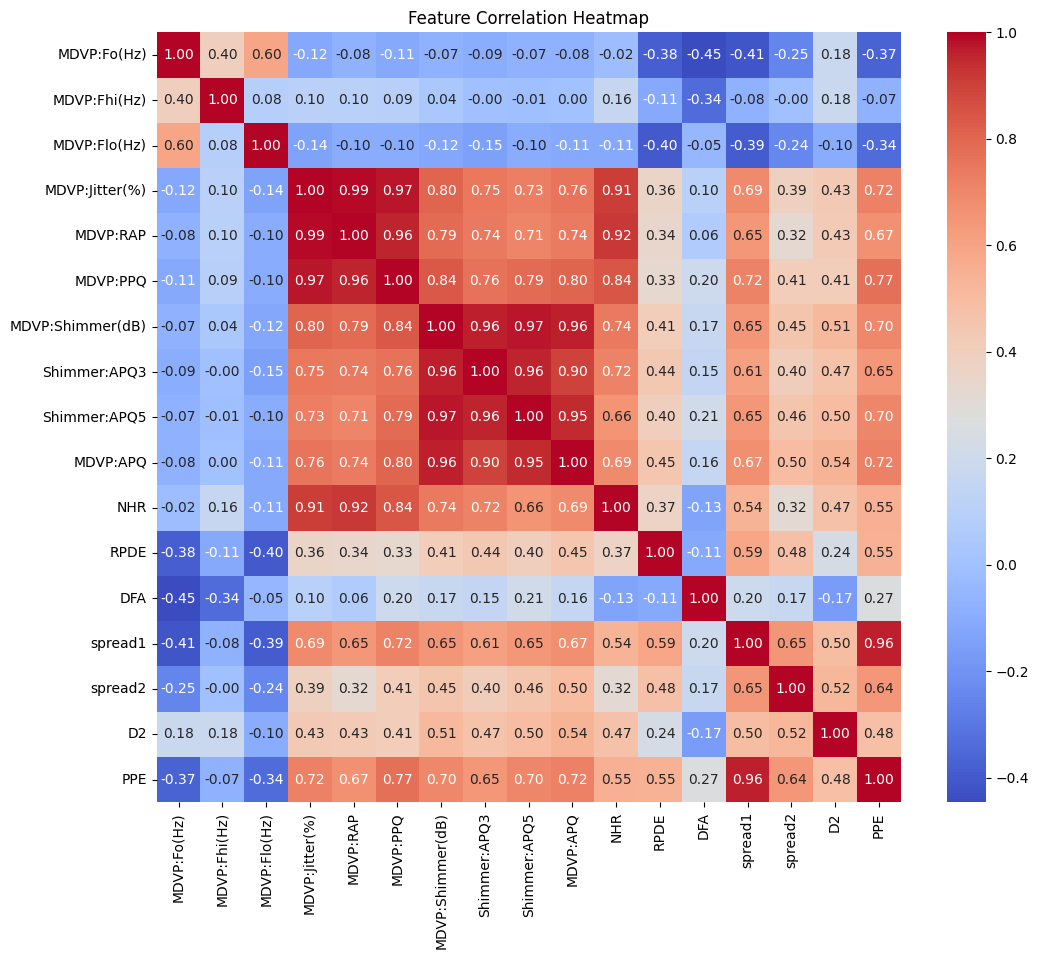

In [12]:
X1 = X.drop(columns=["MDVP:Shimmer","MDVP:Jitter(Abs)","Shimmer:DDA","Jitter:DDP","HNR"])
for feature in X1.columns:
    print(f"{feature:25s}")

plt.figure(figsize=(12, 10))
sns.heatmap(X1.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

We notice redundency still exists

MDVP:Jitter(%), MDVP:RAP, and MDVP:PPQ are all highly corelated(0,97-0.99), as they all measure voice jitter/period perturbation. We will need to drop two of three to avoid redundancy, we will keep MDVP:jitter(%) since it is the simplest and most straightforward measure of the 3. 

Also MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, and MDVP:APQ, all highly correlated. We will drop MDVP:Shimmer(dB), and shimmer:apq5, since they have the  highest correlation to everything among these 4 features.

PPE and spread1 are highly correlated (0.96), we will keep PPE of the 2 since it's a more sophisticated nonlinear measure of fundamental frequency variation, while spread1 is a simpler measure. 

MDVP:Fo(Hz)              
MDVP:Fhi(Hz)             
MDVP:Flo(Hz)             
MDVP:Jitter(%)           
Shimmer:APQ3             
MDVP:APQ                 
NHR                      
RPDE                     
DFA                      
spread2                  
D2                       
PPE                      


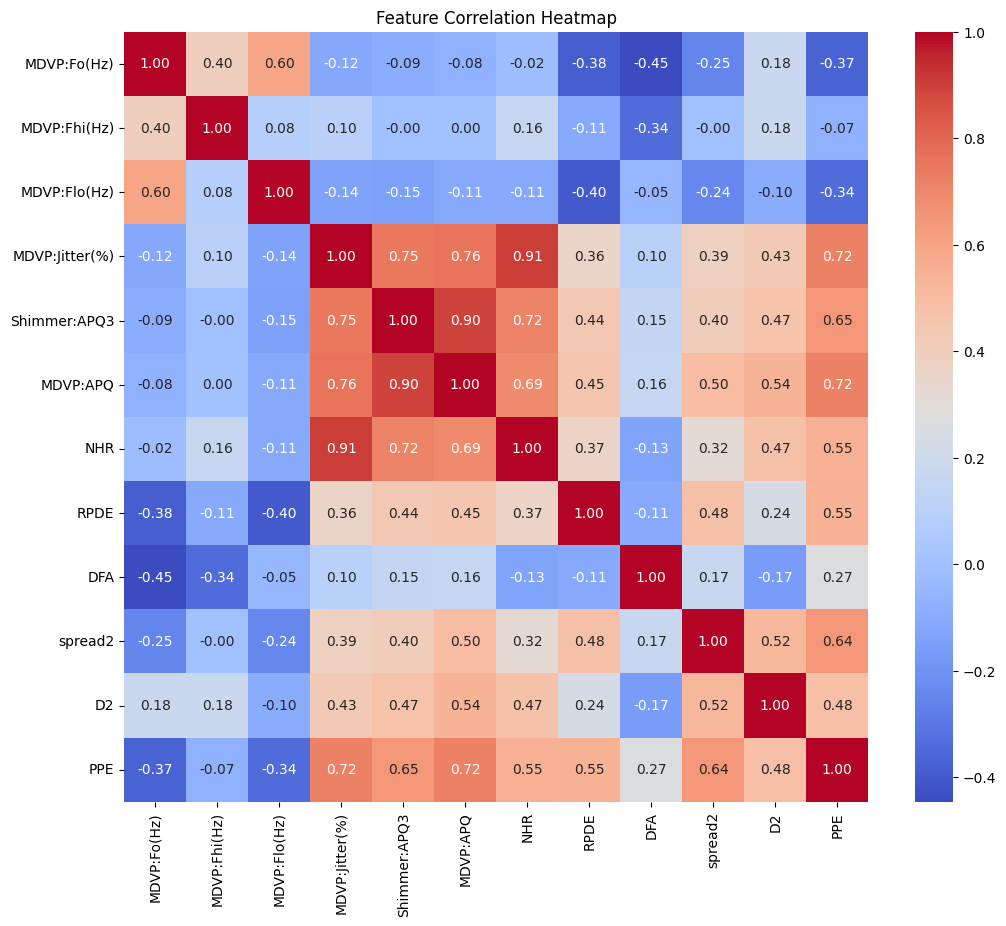

In [13]:
X_reduced = X1.drop(columns=["MDVP:RAP","MDVP:PPQ","Shimmer:APQ5","MDVP:Shimmer(dB)","spread1"])
for feature in X_reduced.columns:
    print(f"{feature:25s}")

plt.figure(figsize=(12, 10))
sns.heatmap(X_reduced.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

For the most part, we got rid of high correlation hence redundancy and noise.

Now we will see what are the most important features:

To find out the important features, we see research such as the research.pdf found in the drive, which utilized the same data set we are using, reached a similar feature set to ours, which is reassuring that we indeed eliminated only redundant features.

We will also now try to use multiple models on our feature set, and see the coefficients to find the features with most significance.

Before we continue, we will just show our final feature set:

In [14]:
print(X_reduced.head())

print(f"size of X:{X_reduced.shape}")

   MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  Shimmer:APQ3  \
0      119.992       157.302        74.997         0.00784       0.02182   
1      122.400       148.650       113.819         0.00968       0.03134   
2      116.682       131.111       111.555         0.01050       0.02757   
3      116.676       137.871       111.366         0.00997       0.02924   
4      116.014       141.781       110.655         0.01284       0.03490   

   MDVP:APQ      NHR      RPDE       DFA   spread2        D2       PPE  
0   0.02971  0.02211  0.414783  0.815285  0.266482  2.301442  0.284654  
1   0.04368  0.01929  0.458359  0.819521  0.335590  2.486855  0.368674  
2   0.03590  0.01309  0.429895  0.825288  0.311173  2.342259  0.332634  
3   0.03772  0.01353  0.434969  0.819235  0.334147  2.405554  0.368975  
4   0.04465  0.01767  0.417356  0.823484  0.234513  2.332180  0.410335  
size of X:(195, 12)


We reduced our original 22 features to only 12, very good for efficiency and noise-elimination.

## Section 2: Testing


## Trial one, using logistic regression
--------------------------------------------------------------------------------------------------------------------------------------------------


We first see the 0/1 split in our dataset

In [16]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_reduced, y, groups))
X_train, X_test = X_reduced.iloc[train_idx], X_reduced.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
print(f"y original values {y.value_counts()}")

print(f"y test values {y_test.value_counts()}")


y original values status
1    147
0     48
Name: count, dtype: int64
y test values status
1    32
0     7
Name: count, dtype: int64


We notice not an equal balance of 0 and 1s, nor equal ratio of 0 and 1 between test and original, so we'll utilize stratified splits to guarantee to ghet an equal split.

#### **The actual Trial**

We will now try applying logistic regression to our X set and see the results.

We will allow for higher powers than 1 on features, since we will try to capture nonlinear relationships if possible.

*Note that since we have multiple voice samples per patient, we will split by group as to avoid data leakage (correlation from voice to voice being from the same patient) and to get more accurate results. So each group will include all the voice samples of a given patient, and a group can be in only 1 set, train, val, or test.*


In [28]:

#group-aware and imbalance aware train/test split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(sgkf.split(X_reduced, y, groups))

X_train, X_test = X_reduced.iloc[train_idx], X_reduced.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]
y_test.value_counts()

status
1    28
0    11
Name: count, dtype: int64

Notice we got a closer ratio to the amount we want to reflect the original dataset's ratio, which will mean we will now generalize better to the dataset.

Since our data set is small (195 samples) we will use kfold validation.

We will try each of l1, l2, and no regualrization, on different models, and see which performs best.

In [31]:
#pipeline
pipe = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=2000,
        random_state=42
    ))
])
gkf_inner = GroupKFold(n_splits=5)

Cs = np.logspace(-4, 2, 25)
# Valid solver/penalty combos for this sklearn:

param_grid = [
    {
        "poly__degree": [1, 2,3,4],
        "logreg__solver": ["lbfgs"],
        "logreg__penalty": ["l2", None],
        "logreg__C": Cs
    },
    {
        "poly__degree": [1, 2, 3,4],
        "logreg__solver": ["saga"],
        "logreg__penalty": ["l1", "l2", None],
        "logreg__C": Cs,
    }
]


grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=gkf_inner,
    scoring="accuracy",
    n_jobs=n_job,
    verbose=2
)

grid.fit(X_train, y_train, groups=groups_train)


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'logreg__C': array([1.0000...00000000e+02]), 'logreg__penalty': ['l2', None], 'logreg__solver': ['lbfgs'], 'poly__degree': [1, 2, ...]}, {'logreg__C': array([1.0000...00000000e+02]), 'logreg__penalty': ['l1', 'l2', ...], 'logreg__solver': ['saga'], 'poly__degree': [1, 2, ...]}]"
,scoring,'accuracy'
,n_jobs,6
,refit,True
,cv,GroupKFold(n_...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,4


Best params (CV on train): {'logreg__C': np.float64(1.7782794100389228), 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'poly__degree': 4}
Best mean CV accuracy (train): 0.9231854838709678

=== FINAL TEST EVALUATION ===
Test accuracy: 0.8717948717948718
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.85      1.00      0.92        28

    accuracy                           0.87        39
   macro avg       0.92      0.77      0.81        39
weighted avg       0.89      0.87      0.86        39

All results saved to logreg_results_Ch1.csv


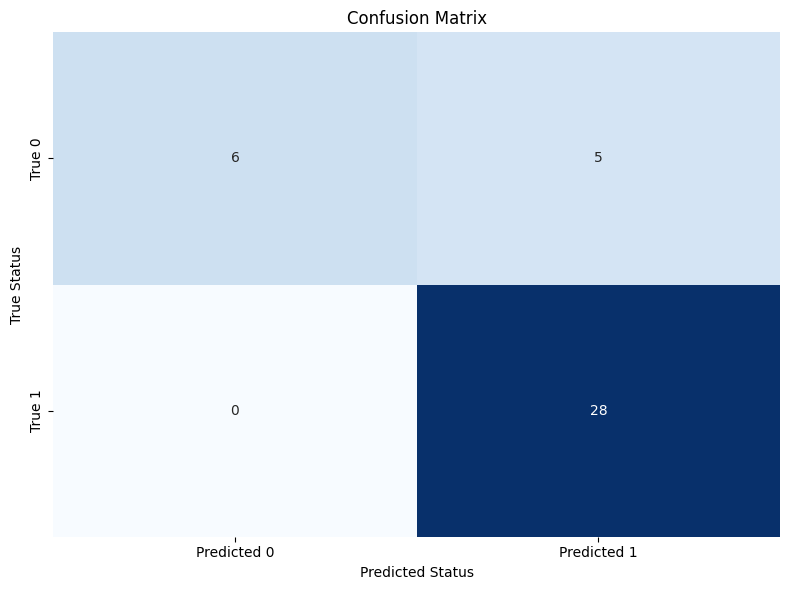

In [ ]:

print("Best params (CV on train):", grid.best_params_)
print("Best mean CV accuracy (train):", grid.best_score_)

# Refit on full TRAIN and evaluate once on TEST
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print("\n=== FINAL TEST EVALUATION ===")
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# === After grid search ===
results_df = pd.DataFrame(grid.cv_results_)

# Extract relevant info
records = []
for i, row in results_df.iterrows():
    params = row["params"]
    solver = params["logreg__solver"]
    degree = params["poly__degree"]
    penalty = params["logreg__penalty"]
    C = params["logreg__C"]
    l1_ratio = params.get("logreg__l1_ratio", None)
    
    record = {
        "method": "LogisticRegression",
        "solver": solver,
        "degree": degree,
        "alpha": 1.0 / C,   # inverse of C
        "generalization": penalty if penalty != "elasticnet" else f"elasticnet(l1_ratio={l1_ratio})",
        "score": row["mean_test_score"]
    }
    records.append(record)

summary_df = pd.DataFrame(records)

summary_df.to_csv("logreg_results_Ch1.csv", index=False)
print("All results saved to logreg_results_Ch1.csv")
# === Plot predictions vs truth for best model ===
y_pred = best_model.predict(X_test)


y_pred = grid.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Use seaborn for a nice heatmap visualization
sns.heatmap(
    cm,
    annot=True,
    fmt='d', # 'd' formats the numbers as integers
    cmap='Blues',
    cbar=False,
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['True 0', 'True 1']
)
plt.xlabel('Predicted Status')
plt.ylabel('True Status')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


We will now run some metrics to see if we are overfitting, and what did best for features:

MODEL EVALUATION


Best CV Score (Train): 0.9232
Test Accuracy          : 0.8718
Test ROC-AUC           : 0.9708

Train-Test Gap       : 0.0514
Slight overfitting detected

Best Parameters:
Polynomial Degree: 4
Regularization C : 1.7783
Penalty          : l2


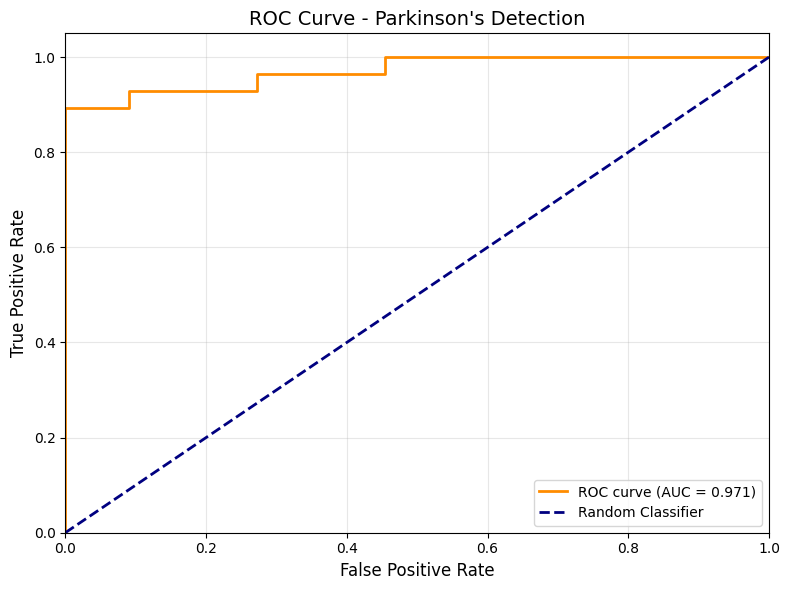

MODEL COEFFICIENTS

Intercept: 7.3494
Total features after polynomial expansion: 1819

Top 15 Most Important Features:
                         Feature  Coefficient  Abs_Coefficient
                    RPDE^2 DFA^2     0.551162         0.551162
                   DFA^3 spread2    -0.520709         0.520709
                   DFA^2 spread2    -0.514456         0.514456
                   MDVP:Fo(Hz)^4    -0.511141         0.511141
      MDVP:Fo(Hz)^3 MDVP:Fhi(Hz)    -0.509125         0.509125
                     DFA spread2    -0.475686         0.475686
                      RPDE DFA^3     0.468094         0.468094
               MDVP:Fo(Hz)^3 NHR    -0.445197         0.445197
                     MDVP:Fo(Hz)     0.429672         0.429672
          MDVP:Fo(Hz) RPDE DFA^2     0.420721         0.420721
      MDVP:Flo(Hz) DFA^2 spread2    -0.409858         0.409858
                         spread2    -0.397553         0.397553
                MDVP:Fo(Hz)^3 D2    -0.397002         0.397002

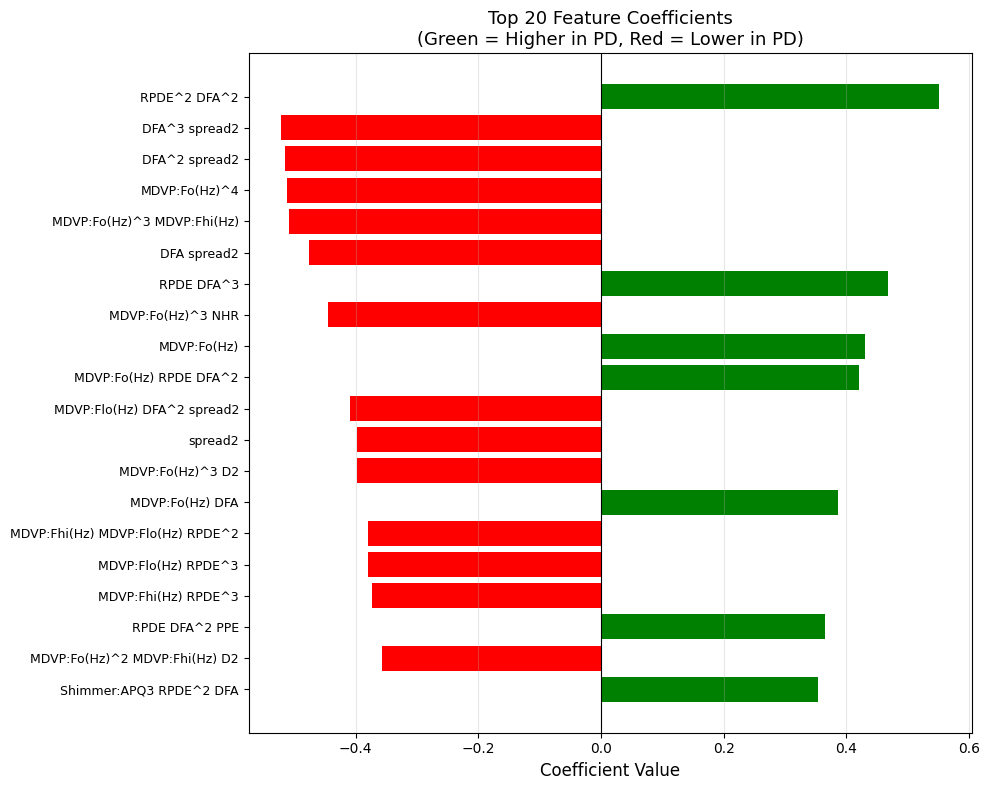

In [33]:
#testing for overfitting usin g simple train-test gap as metric
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("MODEL EVALUATION\n")
print("=" * 60)
print(f"\nBest CV Score (Train): {grid.best_score_:.4f}")
print(f"Test Accuracy          : {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC-AUC           : {roc_auc_score(y_test, y_pred_proba):.4f}")

# Overfitting check
gap = grid.best_score_ - accuracy_score(y_test, y_pred)
print(f"\nTrain-Test Gap       : {gap:.4f}")
if abs(gap) < 0.05:
    print("Good generalization")
elif abs(gap) < 0.10:
    print("Slight overfitting detected")
else:
    print("Significant overfitting")

print(f"\nBest Parameters:")
print(f"Polynomial Degree: {grid.best_params_['poly__degree']}")
print(f"Regularization C : {grid.best_params_['logreg__C']:.4f}")
print(f"Penalty          : {grid.best_params_['logreg__penalty']}")

#Roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Parkinson\'s Detection', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#Model coefficients

print("MODEL COEFFICIENTS")
print("=" * 60)
logreg = best_model.named_steps['logreg']
poly = best_model.named_steps['poly']

# Get feature names
if hasattr(poly, 'get_feature_names_out'):
    feature_names = poly.get_feature_names_out()
else:
    feature_names = [f"feature_{i}" for i in range(len(logreg.coef_[0]))]

coefficients = logreg.coef_[0]
intercept = logreg.intercept_[0]

print(f"\nIntercept: {intercept:.4f}")
print(f"Total features after polynomial expansion: {len(coefficients)}")

# Top coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 15 Most Important Features:")
print(coef_df.head(15).to_string(index=False))

# Plot top coefficients
plt.figure(figsize=(10, 8))
top_n = 20
top_coefs = coef_df.head(top_n)
colors = ['red' if x < 0 else 'green' for x in top_coefs['Coefficient']]
plt.barh(range(len(top_coefs)), top_coefs['Coefficient'].values, color=colors)
plt.yticks(range(len(top_coefs)), top_coefs['Feature'].values, fontsize=9)
plt.xlabel('Coefficient Value', fontsize=12)
plt.title(f'Top {top_n} Feature Coefficients\n(Green = Higher in PD, Red = Lower in PD)', fontsize=13)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)

### *Analysis*
--------------------------------------------------------------------------------------------------------------------------------------------------

From the above, we conclude saga solver seems to give worse results for l2, as apparent from the results csv, and that both l1 and l2 regularization improving our resutls, with two degrees standing out as optimal, 3 and 4.

We will need to test on degree 5 to see if we can add more complexity safely or not.

It seems that MDVP:FO(hz) is a very important metric, being used in most top 20 important coefficients. Additionally, spread 2 seems very important as well, also appearing very commonly.

It also seems that the relationship between the features and the output is nonlinear, as most significant features are mostly higher powers one (only exceptions are spread2 and MDVP:FO(HZ)).

--------------------------------------------------------------------------------------------------------------------------------------------------


#### Trying degree 5

As we mentioned, we will need to try out degree 5 to see if we can benefit from more complex models:

testing for previously done stuff:

In [42]:
Cs = np.logspace(-4, 1, 30) #We lower possible range of values since computing for degree 5+ is expensive
pipe = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=2000,
        random_state=42
    ))
])
gkf_inner = GroupKFold(n_splits=5)
# Valid solver/penalty combos for this sklearn:
param_grid = [
    {
        "poly__degree": [4,5],
        "logreg__solver": ["lbfgs"],
        "logreg__penalty": ["l2", None],
        "logreg__C": Cs
    },
    {
        "poly__degree": [4,5],
        "logreg__solver": ["saga"],
        "logreg__penalty": ["l1", None],
        "logreg__C": Cs
    }
]

grid =  GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=gkf_inner,
    scoring="accuracy",
    n_jobs=n_job,
    verbose=2
)

grid.fit(X_train, y_train, groups=groups_train)



Fitting 5 folds for each of 240 candidates, totalling 1200 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'logreg__C': array([1.0000...00000000e+01]), 'logreg__penalty': ['l2', None], 'logreg__solver': ['lbfgs'], 'poly__degree': [4, 5]}, {'logreg__C': array([1.0000...00000000e+01]), 'logreg__penalty': ['l1', None], 'logreg__solver': ['saga'], 'poly__degree': [4, 5]}]"
,scoring,'accuracy'
,n_jobs,6
,refit,True
,cv,GroupKFold(n_...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,5


Best params (CV on train): {'logreg__C': np.float64(0.6210169418915616), 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'poly__degree': 5}
Best mean CV accuracy (train): 0.9360887096774194

=== FINAL TEST EVALUATION ===
Test accuracy: 0.8717948717948718
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.85      1.00      0.92        28

    accuracy                           0.87        39
   macro avg       0.92      0.77      0.81        39
weighted avg       0.89      0.87      0.86        39

All results saved to logreg_Ch1_deg_4_5.csv


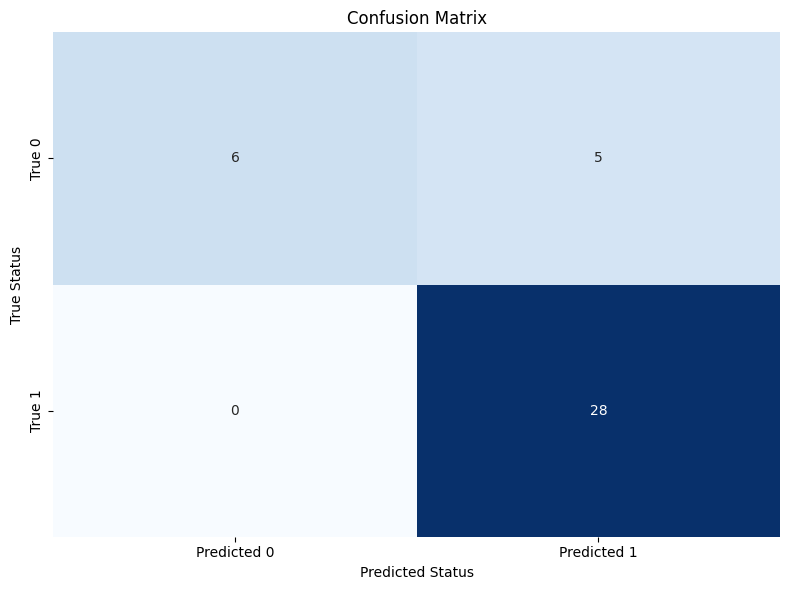

In [43]:
#Save results and test deg 3,4
print("Best params (CV on train):", grid.best_params_)
print("Best mean CV accuracy (train):", grid.best_score_)

# Refit on full TRAIN and evaluate once on TEST
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)
print("\n=== FINAL TEST EVALUATION ===")
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# === After grid search ===
# Save all CV results
results_df = pd.DataFrame(grid.cv_results_)


#Do not save, dataset i did as big as it realistically gets



# Extract relevant info
records = []
for i, row in results_df.iterrows():
    params = row["params"]
    solver = params["logreg__solver"]
    degree = params["poly__degree"]
    penalty = params["logreg__penalty"]
    C = params["logreg__C"]
    l1_ratio = params.get("logreg__l1_ratio", None)
    
    record = {
        "method": "LogisticRegression",
        "solver": solver,
        "degree": degree,
        "alpha": 1.0 / C,   # inverse of C
        "generalization": penalty if penalty != "elasticnet" else f"elasticnet(l1_ratio={l1_ratio})",
        "score": row["mean_test_score"]
    }
    records.append(record)

summary_df = pd.DataFrame(records)

# Save to CSV
summary_df.to_csv("logreg_Ch1_deg_4_5.csv", index=False)
print("All results saved to logreg_Ch1_deg_4_5.csv")

#Confusion
y_pred = grid.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Use seaborn for a nice heatmap visualization
sns.heatmap(
    cm,
    annot=True,
    fmt='d', # 'd' formats the numbers as integers
    cmap='Blues',
    cbar=False,
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['True 0', 'True 1']
)
plt.xlabel('Predicted Status')
plt.ylabel('True Status')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


Same checks as above:

MODEL EVALUATION


Best CV Score (Train): 0.9361
Test Accuracy          : 0.8718
Test ROC-AUC           : 0.9740

Train-Test Gap       : 0.0643
Slight overfitting detected

Best Parameters:
Polynomial Degree: 5
Regularization C : 0.6210
Penalty          : l2


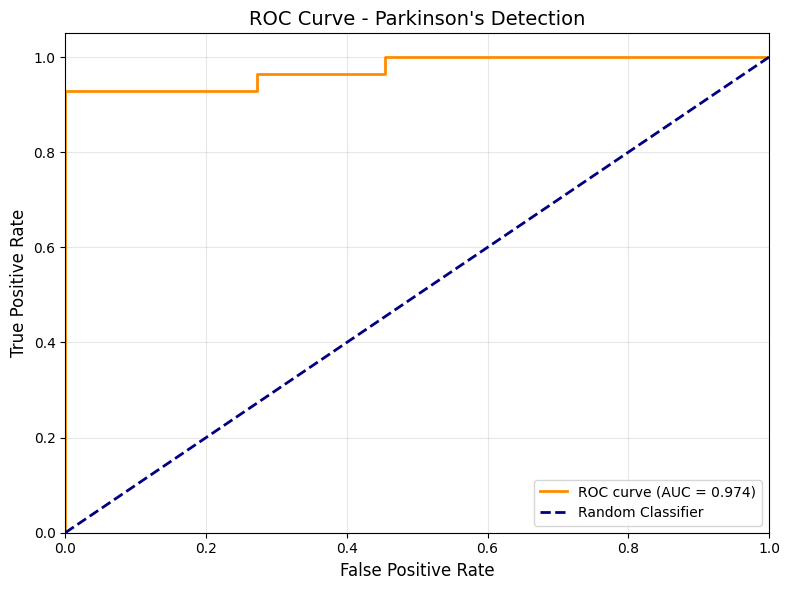

MODEL COEFFICIENTS

Intercept: 7.8600
Total features after polynomial expansion: 6187

Top 15 Most Important Features:
                         Feature  Coefficient  Abs_Coefficient
                    RPDE^2 DFA^3     0.257919         0.257919
                   DFA^3 spread2    -0.244510         0.244510
                   DFA^4 spread2    -0.240684         0.240684
                   DFA^2 spread2    -0.238252         0.238252
                     DFA spread2    -0.217640         0.217640
      MDVP:Fo(Hz)^4 MDVP:Fhi(Hz)    -0.215674         0.215674
                     MDVP:Fo(Hz)     0.209941         0.209941
                   MDVP:Fo(Hz)^5    -0.206663         0.206663
      MDVP:Flo(Hz) DFA^3 spread2    -0.206034         0.206034
               MDVP:Fo(Hz)^4 NHR    -0.194638         0.194638
MDVP:Fhi(Hz) MDVP:Flo(Hz) RPDE^3    -0.190357         0.190357
                    RPDE^3 DFA^2     0.188971         0.188971
                 MDVP:Fo(Hz) DFA     0.187882         0.187882

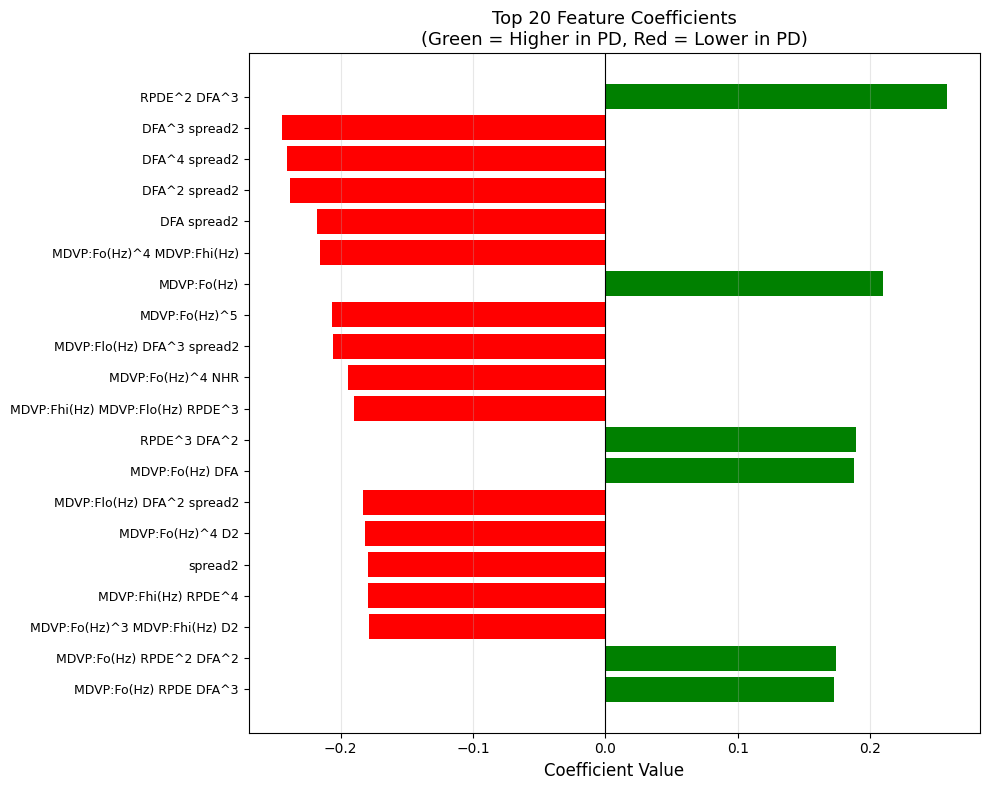

In [44]:
#testing for overfitting usin g simple train-test gap as metric
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("MODEL EVALUATION\n")
print("=" * 60)
print(f"\nBest CV Score (Train): {grid.best_score_:.4f}")
print(f"Test Accuracy          : {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC-AUC           : {roc_auc_score(y_test, y_pred_proba):.4f}")

# Overfitting check
gap = grid.best_score_ - accuracy_score(y_test, y_pred)
print(f"\nTrain-Test Gap       : {gap:.4f}")
if abs(gap) < 0.05:
    print("Good generalization")
elif abs(gap) < 0.10:
    print("Slight overfitting detected")
else:
    print("Significant overfitting")

print(f"\nBest Parameters:")
print(f"Polynomial Degree: {grid.best_params_['poly__degree']}")
print(f"Regularization C : {grid.best_params_['logreg__C']:.4f}")
print(f"Penalty          : {grid.best_params_['logreg__penalty']}")

#Roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Parkinson\'s Detection', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#Model coefficients

print("MODEL COEFFICIENTS")
print("=" * 60)
logreg = best_model.named_steps['logreg']
poly = best_model.named_steps['poly']

# Get feature names
if hasattr(poly, 'get_feature_names_out'):
    feature_names = poly.get_feature_names_out()
else:
    feature_names = [f"feature_{i}" for i in range(len(logreg.coef_[0]))]

coefficients = logreg.coef_[0]
intercept = logreg.intercept_[0]

print(f"\nIntercept: {intercept:.4f}")
print(f"Total features after polynomial expansion: {len(coefficients)}")

# Top coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 15 Most Important Features:")
print(coef_df.head(15).to_string(index=False))

# Plot top coefficients
plt.figure(figsize=(10, 8))
top_n = 20
top_coefs = coef_df.head(top_n)
colors = ['red' if x < 0 else 'green' for x in top_coefs['Coefficient']]
plt.barh(range(len(top_coefs)), top_coefs['Coefficient'].values, color=colors)
plt.yticks(range(len(top_coefs)), top_coefs['Feature'].values, fontsize=9)
plt.xlabel('Coefficient Value', fontsize=12)
plt.title(f'Top {top_n} Feature Coefficients\n(Green = Higher in PD, Red = Lower in PD)', fontsize=13)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)

### Analysis

--------------------------------------------------------------------------------------------------------------------------------------------------
It seems we can still benefit from higher degrees as shown here, where degree 5 gave us new best feature combination, as well as better results than degree 4.

We wil still need to test on degree 6, since it seems we are benefitting from more complexity.

### Trying on degree 6:

Same logic as before, but now testing for degree  6:

In [45]:
Cs = np.logspace(-4, 1, 25) #We lower possible range of values since computing for degree 5+ is expensive

pipe = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=2000,
        random_state=42
    ))
])
gkf_inner = GroupKFold(n_splits=5)

# Valid solver/penalty combos for this sklearn:
param_grid = [
    {
        "poly__degree": [6],
        "logreg__solver": ["lbfgs"],
        "logreg__penalty": ["l2", None],
        "logreg__C": Cs
    }
]

grid =  GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=gkf_inner,
    scoring="accuracy",
    n_jobs=n_job,
    verbose=2
)

grid.fit(X_train, y_train, groups=groups_train)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'logreg__C': array([1.0000...00000000e+01]), 'logreg__penalty': ['l2', None], 'logreg__solver': ['lbfgs'], 'poly__degree': [6]}]"
,scoring,'accuracy'
,n_jobs,6
,refit,True
,cv,GroupKFold(n_...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,6


Best params (CV on train): {'logreg__C': np.float64(0.3480700588428413), 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'poly__degree': 6}
Best mean CV accuracy (train): 0.9233870967741936

=== FINAL TEST EVALUATION ===
Test accuracy: 0.8717948717948718
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.85      1.00      0.92        28

    accuracy                           0.87        39
   macro avg       0.92      0.77      0.81        39
weighted avg       0.89      0.87      0.86        39

All results saved to results_Ch1_deg_6.csv


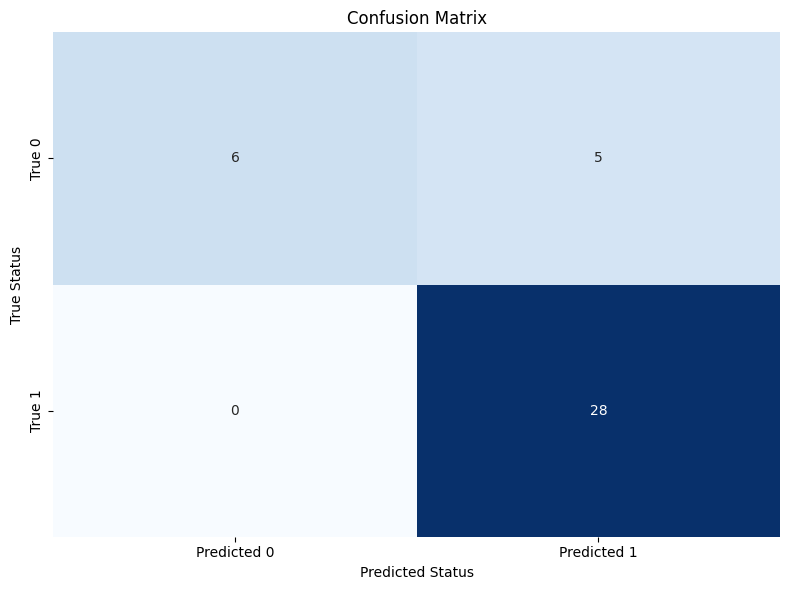

In [46]:
print("Best params (CV on train):", grid.best_params_)
print("Best mean CV accuracy (train):", grid.best_score_)

# Refit on full TRAIN and evaluate once on TEST
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)
print("\n=== FINAL TEST EVALUATION ===")
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# === After grid search ===
# Save all CV results
results_df = pd.DataFrame(grid.cv_results_)


#Do not save, dataset i did as big as it realistically gets



# Extract relevant info
records = []
for i, row in results_df.iterrows():
    params = row["params"]
    solver = params["logreg__solver"]
    degree = params["poly__degree"]
    penalty = params["logreg__penalty"]
    C = params["logreg__C"]
    l1_ratio = params.get("logreg__l1_ratio", None)
    
    record = {
        "method": "LogisticRegression",
        "solver": solver,
        "degree": degree,
        "alpha": 1.0 / C,   # inverse of C
        "generalization": penalty if penalty != "elasticnet" else f"elasticnet(l1_ratio={l1_ratio})",
        "score": row["mean_test_score"]
    }
    records.append(record)

summary_df = pd.DataFrame(records)

# Save to CSV
summary_df.to_csv("logreg_Ch1_deg_6.csv", index=False)
print("All results saved to results_Ch1_deg_6.csv")

#Confusion
y_pred = grid.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Use seaborn for a nice heatmap visualization
sns.heatmap(
    cm,
    annot=True,
    fmt='d', # 'd' formats the numbers as integers
    cmap='Blues',
    cbar=False,
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['True 0', 'True 1']
)
plt.xlabel('Predicted Status')
plt.ylabel('True Status')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


MODEL EVALUATION


Best CV Score (Train): 0.9234
Test Accuracy          : 0.8718
Test ROC-AUC           : 0.9708

Train-Test Gap       : 0.0516
Slight overfitting detected

Best Parameters:
Polynomial Degree: 6
Regularization C : 0.3481
Penalty          : l2


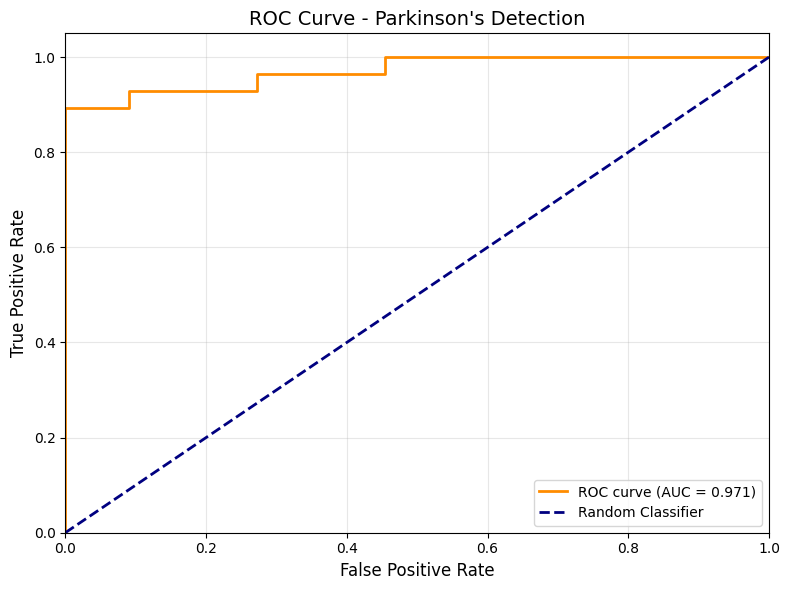

MODEL COEFFICIENTS

Intercept: 8.9246
Total features after polynomial expansion: 18563

Top 15 Most Important Features:
                         Feature  Coefficient  Abs_Coefficient
                    RPDE^2 DFA^4     0.146532         0.146532
                   DFA^3 spread2    -0.144087         0.144087
                   DFA^4 spread2    -0.141665         0.141665
                   DFA^2 spread2    -0.140735         0.140735
                    RPDE^3 DFA^3     0.140161         0.140161
                   DFA^5 spread2    -0.135364         0.135364
                     MDVP:Fo(Hz)     0.134715         0.134715
                     DFA spread2    -0.129097         0.129097
      MDVP:Flo(Hz) DFA^4 spread2    -0.122239         0.122239
                 MDVP:Fo(Hz) DFA     0.119319         0.119319
      MDVP:Flo(Hz) DFA^3 spread2    -0.115790         0.115790
MDVP:Fhi(Hz) MDVP:Flo(Hz) RPDE^4    -0.113340         0.113340
        MDVP:Fo(Hz) RPDE^2 DFA^3     0.112124         0.11212

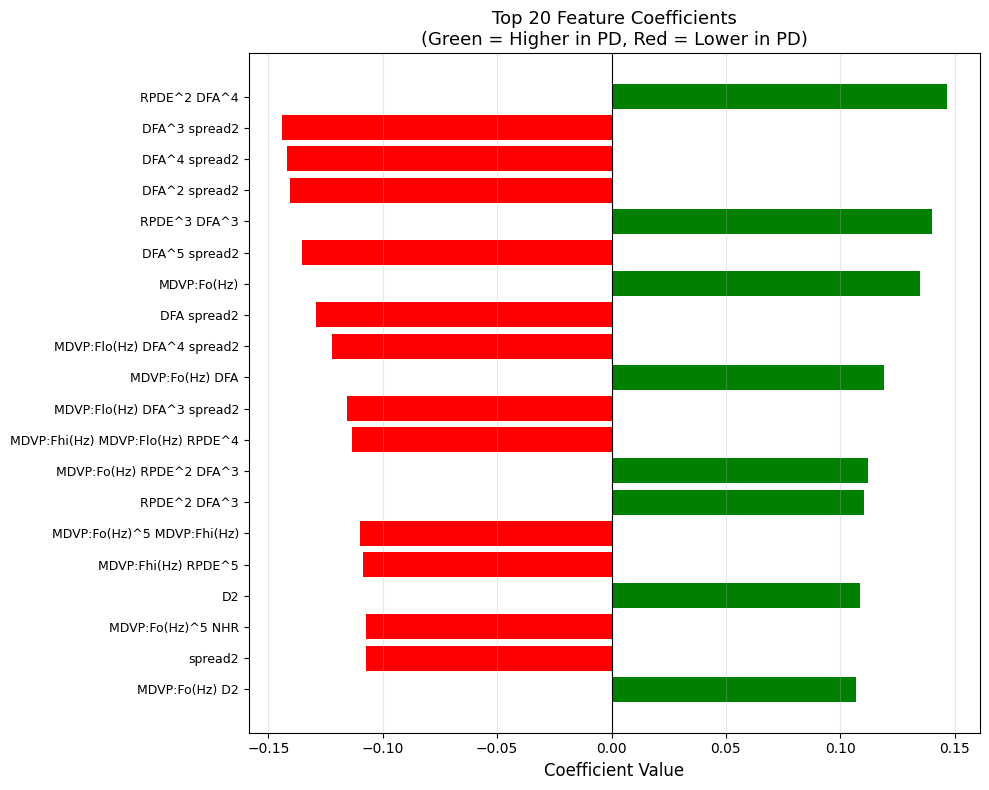

In [47]:
#testing for overfitting usin g simple train-test gap as metric
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("MODEL EVALUATION\n")
print("=" * 60)
print(f"\nBest CV Score (Train): {grid.best_score_:.4f}")
print(f"Test Accuracy          : {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC-AUC           : {roc_auc_score(y_test, y_pred_proba):.4f}")

# Overfitting check
gap = grid.best_score_ - accuracy_score(y_test, y_pred)
print(f"\nTrain-Test Gap       : {gap:.4f}")
if abs(gap) < 0.05:
    print("Good generalization")
elif abs(gap) < 0.10:
    print("Slight overfitting detected")
else:
    print("Significant overfitting")

print(f"\nBest Parameters:")
print(f"Polynomial Degree: {grid.best_params_['poly__degree']}")
print(f"Regularization C : {grid.best_params_['logreg__C']:.4f}")
print(f"Penalty          : {grid.best_params_['logreg__penalty']}")

#Roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Parkinson\'s Detection', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#Model coefficients

print("MODEL COEFFICIENTS")
print("=" * 60)
logreg = best_model.named_steps['logreg']
poly = best_model.named_steps['poly']

# Get feature names
if hasattr(poly, 'get_feature_names_out'):
    feature_names = poly.get_feature_names_out()
else:
    feature_names = [f"feature_{i}" for i in range(len(logreg.coef_[0]))]

coefficients = logreg.coef_[0]
intercept = logreg.intercept_[0]

print(f"\nIntercept: {intercept:.4f}")
print(f"Total features after polynomial expansion: {len(coefficients)}")

# Top coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 15 Most Important Features:")
print(coef_df.head(15).to_string(index=False))

# Plot top coefficients
plt.figure(figsize=(10, 8))
top_n = 20
top_coefs = coef_df.head(top_n)
colors = ['red' if x < 0 else 'green' for x in top_coefs['Coefficient']]
plt.barh(range(len(top_coefs)), top_coefs['Coefficient'].values, color=colors)
plt.yticks(range(len(top_coefs)), top_coefs['Feature'].values, fontsize=9)
plt.xlabel('Coefficient Value', fontsize=12)
plt.title(f'Top {top_n} Feature Coefficients\n(Green = Higher in PD, Red = Lower in PD)', fontsize=13)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)

### Analysis:

------------------------------------------------------------------------------------------------------------------------------------------------------

It seems that best degree is between degree 3 and 5, getting us highest accuracy and results for minimal complexity, with l2 being the best generalization method overall using lbfgs solver.

Our relation with the output is clearly non-linear, as multi-degree models far outdo simple degree 1 models.

We are always capturing all true positives, but struggle with tru negatives. We care most about classifying all true positives correctly, with secondary focus on true negatives, due to caring more about classifying PD patients, than falsely classifying healthy, as one is more of an issue. So we don't mind the results, but we would like to improve our accuracy overall.

We will try to see how we can check why misclassification is happening in the first place.



### Checking why misclassification happens:

We will start more general, see how far from the decision threshold the misclassified points are

In [49]:
y_proba = best_model.predict_proba(X_test)[:,1]
# Make a DataFrame to inspect
results_df = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_pred,
    'Probability Class 1': y_proba
})

# Add a column to identify misclassifications
results_df['Correct?'] = results_df['True Label'] == results_df['Predicted Label']
results_df['Distance from 0.5'] = np.abs(results_df['Probability Class 1'] - 0.5)

# Sort misclassifications by how close the model was to flipping the decision
close_calls = results_df[results_df['Correct?'] == False].sort_values(by='Distance from 0.5')

print(close_calls.head(10))  # Look at the 10 closest incorrect predictions

     True Label  Predicted Label  Probability Class 1  Correct?  \
171           0                1             0.588417     False   
185           0                1             0.618604     False   
176           0                1             0.759773     False   
190           0                1             0.831724     False   
35            0                1             0.889701     False   

     Distance from 0.5  
171           0.088417  
185           0.118604  
176           0.259773  
190           0.331724  
35            0.389701  


It seems that, for some examples, we are quite away from the correct threshold (atleast for degree 6 model, could be more/less elsewhere) which is bad. The way we can solve our issue is a better model or even giving higher balance/weight towards 1, defining the true label to be from below 0.5 and up (shifting the decision boundary downwards), or perhaps a better dataset that is more balanced between 0 and 1s.

In any case, we will look at the most extreme result of the misclassified to see what happened:

In [50]:
extreme_case_index = 35  #replace with index of interest

X_test.loc[extreme_case_index]

MDVP:Fo(Hz)       201.464000
MDVP:Fhi(Hz)      210.565000
MDVP:Flo(Hz)      195.708000
MDVP:Jitter(%)      0.001980
Shimmer:APQ3        0.005860
MDVP:APQ            0.009570
NHR                 0.001350
RPDE                0.344252
DFA                 0.742737
spread2             0.170183
D2                  2.447064
PPE                 0.057610
Name: 35, dtype: float64

See the means for clsas = 0 and class = 1, and see contribution of each feature to the decision:

In [51]:
#Comapre the misclassifeid example features to each class's mean 
row_raw = X_test.loc[extreme_case_index]

class0_mean = X_train[y_train==0].mean()
class1_mean = X_train[y_train==1].mean()

comparison_df = pd.DataFrame({
    'row_raw': row_raw,
    'class0_mean': class0_mean,
    'class1_mean': class1_mean
})
print(comparison_df)

logreg = best_model.named_steps['logreg']
preprocessor = best_model[:-1]

# Transform the row to match model input space
row_transformed = preprocessor.transform(row_raw.to_frame().T)  # shape (1, n_features)

#Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

#Create a Series for transformed row
row_transformed_series = pd.Series(row_transformed.flatten(), index=feature_names)

#Coefficients in transformed space
coefs = pd.Series(logreg.coef_[0], index=feature_names)

contrib = row_transformed_series * coefs
#top features pushing towards class 1 (largest positive contributions)
top_class1 = contrib.sort_values(ascending=False).head(10)

#top features pushing towards class 0 (largest negative contributions)
top_class0 = contrib.sort_values().head(10)

print("\nTop features pushing towards class 1:")
print(top_class1)

print("\nTop features pushing towards class 0:")
print(top_class0)

                   row_raw  class0_mean  class1_mean
MDVP:Fo(Hz)     201.464000   182.585865   145.349782
MDVP:Fhi(Hz)    210.565000   230.544459   189.734261
MDVP:Flo(Hz)    195.708000   148.980135   107.335958
MDVP:Jitter(%)    0.001980     0.004096     0.006982
Shimmer:APQ3      0.005860     0.009295     0.017765
MDVP:APQ          0.009570     0.013057     0.027912
NHR               0.001350     0.012971     0.028280
RPDE              0.344252     0.447031     0.516379
DFA               0.742737     0.693963     0.726888
spread2           0.170183     0.166888     0.248621
D2                2.447064     2.143160     2.454355
PPE               0.057610     0.122910     0.233914

Top features pushing towards class 1:
MDVP:Fo(Hz) DFA            0.181004
MDVP:Fo(Hz)                0.155644
MDVP:Fo(Hz) DFA^2          0.152933
MDVP:Flo(Hz) D2            0.135525
MDVP:Flo(Hz)^2 D2^2        0.117830
MDVP:Flo(Hz) D2^2          0.117686
MDVP:Fo(Hz) DFA D2         0.110345
MDVP:Fo(Hz) D2      

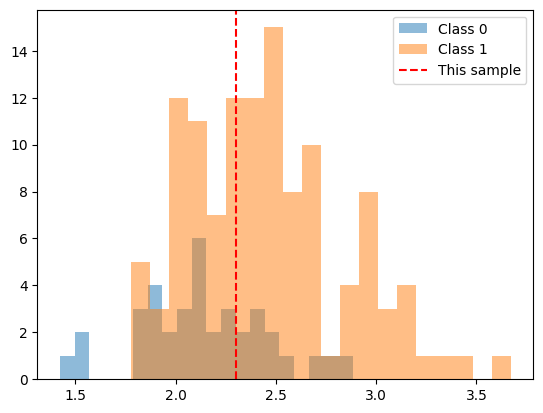

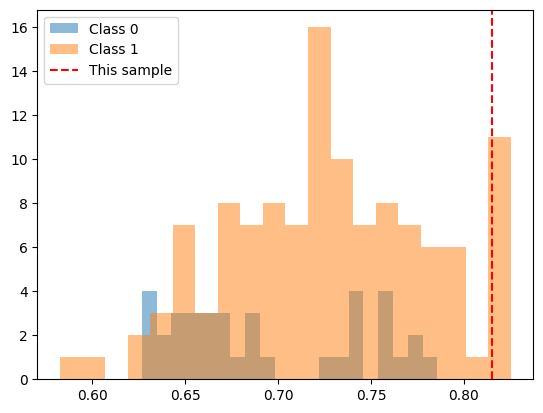

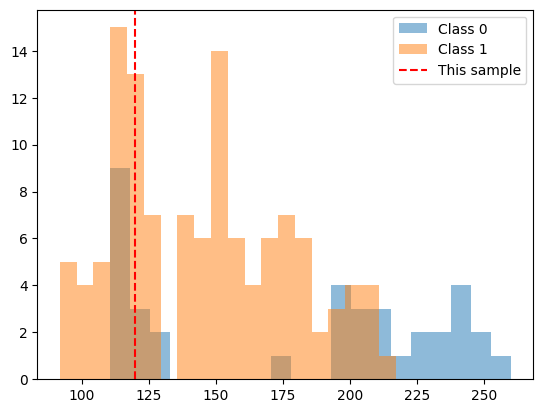

In [52]:
row = X_test.iloc[0]  

#To see effect of particular feature on prediction:
feature = 'D2'
plt.hist(X_train.loc[y_train==0, feature], bins=20, alpha=0.5, label='Class 0')
plt.hist(X_train.loc[y_train==1, feature], bins=20, alpha=0.5, label='Class 1')
plt.axvline(row[feature], color='red', linestyle='--', label='This sample')
plt.legend()
plt.show()

feature = 'DFA'
plt.hist(X_train.loc[y_train==0, feature], bins=20, alpha=0.5, label='Class 0')
plt.hist(X_train.loc[y_train==1, feature], bins=20, alpha=0.5, label='Class 1')
plt.axvline(row[feature], color='red', linestyle='--', label='This sample')
plt.legend()
plt.show()

feature = 'MDVP:Fo(Hz)'
plt.hist(X_train.loc[y_train==0, feature], bins=20, alpha=0.5, label='Class 0')
plt.hist(X_train.loc[y_train==1, feature], bins=20, alpha=0.5, label='Class 1')
plt.axvline(row[feature], color='red', linestyle='--', label='This sample')
plt.legend()
plt.show()

So we see our misclassifcation occurs due to key features being in the region where most examples were classified as class 1 rather than class 0, hence the misclassification.

This tells us that logistic regression is not doing good enough of a job seperating the two classes, perhaps due to limitations on degrees or just not finding the optimal alpha for regualrization.

To finally show that our dataset is indeed not linearly seperable, we will use PCA. If it clusters successfully and cleanly, then we have a linearly seperable class, and is solvable using linear methods (achieving near 100% accuracy). If not, we need non-linearity to do any good (NNs and such).

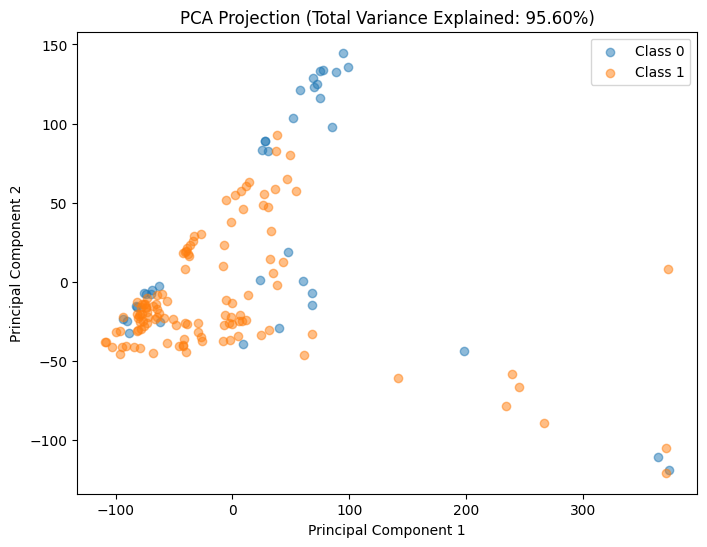

In [53]:
from sklearn.decomposition import PCA
# Fit PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Compute total variance explained
total_var = pca.explained_variance_ratio_.sum() * 100

# Plot PCA projection
plt.figure(figsize=(8,6))
plt.scatter(X_pca[y_train == 0, 0], X_pca[y_train == 0, 1], label='Class 0', alpha=0.5)
plt.scatter(X_pca[y_train == 1, 0], X_pca[y_train == 1, 1], label='Class 1', alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'PCA Projection (Total Variance Explained: {total_var:.2f}%)')
plt.legend()
plt.show()

Clearly not a clean split of 2 classes, we will need non-linearity, so need to use degrees for other linear models (SVMs) to make it be able to capture non-linearity. Or we switch to another dataset, and see the type of distribution we get there (could be more linear).

### Analysis

------------------------------------------------------------------------------------------------------------------------------------------------------

It seems the reason we are misclassifying it here is due to the main features all falling within class 1 classification territory, thus making the model mistake it for a class 1, we need better seperation of the 2 classes to do better.

Our inputs and output are most definitely not linear.

## Chapter 1 Conclusion:

Degree 3 and 4 seem to be the best, giving the highest, most consistent test resutls

Our relationship between inputs and outputs is not linear, and needs degrees in logistic to do any good.

Our dataset is small, and we'll need a bigger dataset to be able to generalize better.

We need to do groupstratifiedkfold to avoid having multiple voices from same patient be in different sets (test, train, val).

------------------------------------------------------------------------------------------------------------------------------------------------------